$$\fbox{Global Model} \rightarrow \fbox{Most Relevant Attributes} \rightarrow \fbox{Extract Attribute Patterns} \rightarrow \fbox{Analyzing Patterns}$$

#### Global Model:
- Random Tree

#### Most Relevant Attributes:
- sample the neighborhood of each point (original point)
- classify the samples with the Global Model
- build local models (random tree fitted in the sampled points)
- extract the k% most relevant attributes for each instance (this gives rise to a binary array)

#### Extract Attribute Patterns:
- split the binary representation of relevant attributes per class
- filter out the binary representation of relevant attributes to extrat patterns

#### Analyzing Patterns:
- patterns from each class are compared to find similarities and discrepancies 

In [1]:
import sys
import numpy as np
import pandas as pd
from scipy import stats
#from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import cluster

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

## Reading data

In [2]:
df = pd.read_csv("Data/heloc_dataset_v1.csv")

X_data = df.iloc[:,1:].values
X_data = stats.zscore(X_data,axis=0)
Y_classes = np.asarray([1 if df.iloc[i,0] == "Good" else 0 for i in range(df.shape[0])],dtype=int)

print(X_data.shape)

(10459, 23)


## Creating a model by fitting a random forest to the data

In [3]:
rdf = RandomForestClassifier(max_depth=7, n_estimators=15,bootstrap=False)
rdf.fit(X_data,Y_classes)
rdf_pred = rdf.predict(X_data)
rdf_error = np.sum([int(rdf_pred[i] != Y_classes[i]) for i in range(X_data.shape[0])])
print("RdF ",rdf_error, "misclassified data out of", X_data.shape[0], "(",100*(rdf_error/X_data.shape[0]),"%)")

RdF  2551 misclassified data out of 10459 ( 24.390477101061286 %)


## Generating new data around each object from the original data and computing relevant attributes

In [4]:
# number of points generated in the neighborhood of each objetct
n_extras = 50 

# number/percentage of attributes to be considered as the most relevants
percent = 0.20
k_attributes = np.rint(percent*X_data.shape[1]).astype(int) 
print('number of attributes',k_attributes)

# 3D array where extra_neighbors[i] is the matrix containing the new data around X_data[i]
extra_neighbors = np.zeros((X_data.shape[0],n_extras,X_data.shape[1]))

# 2D array where the row extra_neighbors_class[i] corresponds to the classes of the extra neighbors of X_data[i]
extra_neighbors_class = np.zeros((X_data.shape[0],n_extras))

# 2D array where relev_attributes[i,j] == 1 if attribute j is relevant to object i
relev_attributes = np.zeros((X_data.shape[0],X_data.shape[1]))

# computing variance of each attribute in each class (used to define the Normal distribution around each object X_data[i])
classes = np.unique(Y_classes)
variances = np.zeros((len(classes),X_data.shape[1]))
for i in classes:
    cids = np.where(Y_classes == i)[0]
    variances[i]=np.std(X_data[cids],axis=0)

for i in range(X_data.shape[0]):
    # computing the covariace matriz used in the normal distribution
    S = np.multiply(np.identity(X_data.shape[1]),variances[Y_classes[i]]**2)
    
    # generating the extra neighbors from a normal distribution
    extra_neighbors[i] = np.random.multivariate_normal(X_data[i],S,size=n_extras)
    
    # predicting the class of extra_neighbors
    extra_neighbors_class = rdf.predict(extra_neighbors[i])
    
    # fitting a random forest to the extra_neighbors
    # getting the k_attributes most important from the rdf 
    rdfs = RandomForestClassifier(max_depth=5, n_estimators=15,bootstrap=True)
    rdfs.fit(extra_neighbors[i],extra_neighbors_class)
    attribute_relevance = rdfs.feature_importances_
    indices = np.argsort(attribute_relevance)[-k_attributes:]
    relev_attributes[i,indices] = np.ones((k_attributes,)) 
    

number of attributes 5


## Visualizing the most relevant attributes object-wise

In [10]:
classes = np.unique(Y_classes)
nclusters = 6

def group_pattern(GP):
    group = cluster.KMeans(n_clusters=nclusters)
    group.fit(GP)
    gp_lbs = group.labels_
    gp_lbs_unique = np.unique(gp_lbs)
    gp_list = []
    for j in gp_lbs_unique:
        gp_list.append(GP[np.where(gp_lbs == j)[0]])
    g = gp_list[0]
    for i in range(1,len(gp_list)):
        g = np.vstack((g,gp_list[i]))        
    return(g)
        


n = X_data.shape[0]

# this list keep the relevant attributes of each class. The last elements are all classes together
rel_attrib_per_class = []

# each elemenyt of this list stores the indices of the patterns in a class
patterns_per_class = []

# each element is a dictionary: Key is the pattern index; Content is a list ids of those patterns in np.where(Y_classes==classes[i])[0]
pattern_ids_per_class = []

for i in range(len(classes)):
    cids = np.where(Y_classes==classes[i])[0]
    crel = relev_attributes[cids]
    #dbc = cluster.AgglomerativeClustering(n_clusters=5, linkage='single')
    #dbc.fit(np.multiply(crel,X_data[cids]))
    dbc = cluster.KMeans(n_clusters=nclusters)
    dbc.fit(crel)
    
    cl_db = dbc.labels_
    cl_db_unique = np.unique(cl_db)
    pattern_locations = np.zeros((nclusters,),dtype=int)
    pattern_prev = 0
    pattern_ids = {}
    for k,j in enumerate(cl_db_unique):
        where = np.where(cl_db == j)[0]
        temp = crel[where]
        temp = group_pattern(temp)
        pattern_ids[k] = where
        #print("cluster ", j,temp.shape)
        if k == 0:
            pattern_locations[0] = len(temp)
            extracted_rel_attrib = temp
        else:
            pattern_locations[k] = pattern_locations[k-1]+len(temp)
            extracted_rel_attrib = np.vstack((extracted_rel_attrib,temp))
    patterns_per_class.append(pattern_locations)
    rel_attrib_per_class.append(extracted_rel_attrib)
    pattern_ids_per_class.append(pattern_ids)

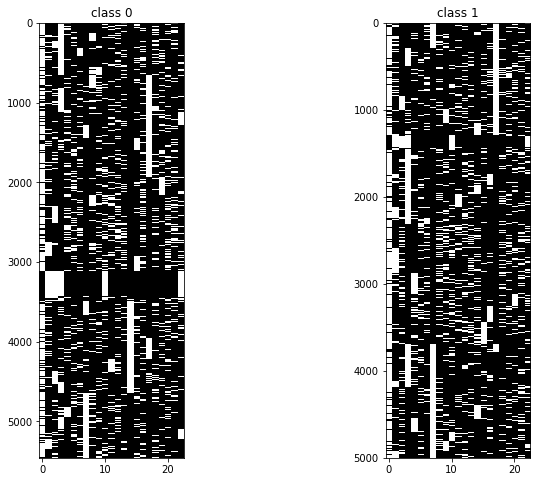

In [11]:
plt.figure(2,figsize=(15,8))

for i in range(len(rel_attrib_per_class)):
    # support 3 classes only
    if i == 0:
        plt.subplot(1,5,1)
        plt.title('class 0')
    else:
        plt.subplot(1,5,i*2+1)
        if i == 1:
            plt.title('class 1')
        else:
            plt.title('class 0 and 1')
    plt.imshow(rel_attrib_per_class[i],cmap='gray',aspect='auto')


## Filtering out relevant attributes 

In [12]:
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
from skimage import filters

### Morphologyical Filtering

In [13]:
# Filtering using morphology

def longer_than(v,k):
    c = np.zeros((v.shape[0],1))
    for i in range(v.shape[0]):
        if (np.sum(v[i-k:i])+np.sum(v[i:i+k])) >= k+2:
            c[i]=1
        else:
            c[i]=0
    return(c)

filtered_rel_attrib_per_class = []
for i in range(len(rel_attrib_per_class)):
    for j in range(X_data.shape[1]):
        if j == 0:
            temp = longer_than(rel_attrib_per_class[i][:,j],5)
        else:
            temp = np.hstack((temp,longer_than(rel_attrib_per_class[i][:,j],7)))
            
    filtered_rel_attrib_per_class.append(temp)

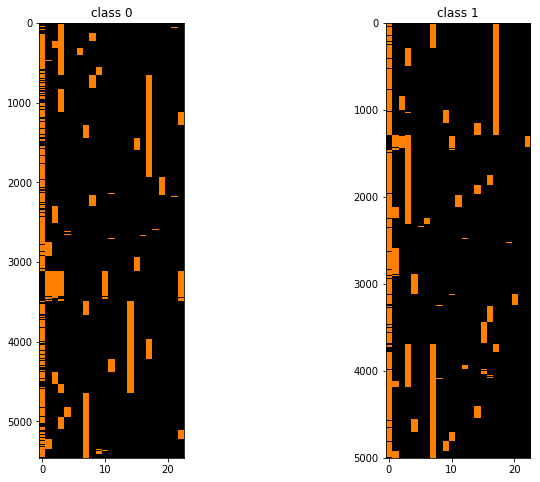

In [14]:
plt.figure(3,figsize=(15,8))

for i in range(len(filtered_rel_attrib_per_class)):
    # support 3 classes only
    c_rgb = np.zeros((filtered_rel_attrib_per_class[i].shape[0],filtered_rel_attrib_per_class[i].shape[1],3))
    c_rgb[:,:,0]=1*filtered_rel_attrib_per_class[i][:,:]
    c_rgb[:,:,1]=0.5*filtered_rel_attrib_per_class[i][:,:]
    if i == 0:
        plt.subplot(1,5,1)
        plt.title('class 0')
    else:
        plt.subplot(1,5,i*2+1)
        if i == 1:
            plt.title('class 1')
        else:
            plt.title('class 0 and 1')

    #plt.imshow(filtered_rel_attrib_per_class[i],cmap='gray',aspect='auto')
    plt.imshow(c_rgb,interpolation='none',aspect='auto')

## Finding relevat attributes shared by classes

In [16]:
centroids = [] 
for i in range(len(filtered_rel_attrib_per_class)):
    prev = 0
    patterns_centroids = np.zeros((nclusters,X_data.shape[1]))
    for j in range(nclusters):
        #print(i,j,patterns_per_class[i][j])
        patterns_centroids[j] = np.mean(filtered_rel_attrib_per_class[i][prev:patterns_per_class[i][j]],axis=0)
        prev = patterns_per_class[i][j]
    centroids.append(patterns_centroids)

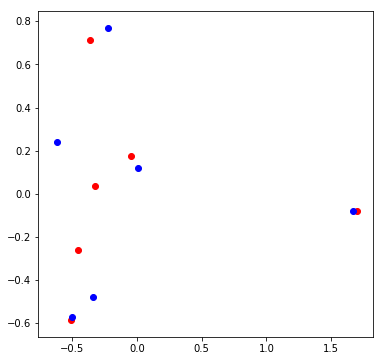

In [17]:
plt.figure(4,figsize=(6,6))
color = ['r','b','g']

for i in range(len(filtered_rel_attrib_per_class)):
    pca_data=PCA(n_components=2)
    data_proj=pca_data.fit_transform(centroids[i])
    plt.scatter(data_proj[:,0],data_proj[:,1],c=color[i])

In [19]:
D = distance_matrix(centroids[0],centroids[1])
D = D + 1.0e7*np.eye(D.shape[0])

similar_patterns = np.argmin(D,axis=1)
print(similar_patterns)
print(D[list(range(D.shape[0])),similar_patterns])

[2 0 3 1 3 4]
[0.41482737 0.36134559 0.37677887 0.21424158 1.13997645 0.87023441]


In [13]:
cids_c0 = X_data[np.where(Y_classes==classes[0])[0]]
cids_c1 = X_data[np.where(Y_classes==classes[1])[0]]

# A = filtered_rel_attrib_per_class[0][0:patterns_per_class[0][0]]
# B = cids_c0[pattern_ids_per_class[0][0]]
# rel_attrib_values_c0_pattern = np.multiply(A,B)
# C = filtered_rel_attrib_per_class[1][patterns_per_class[1][1]:patterns_per_class[1][2]]
# D = cids_c1[pattern_ids_per_class[1][2]]
# rel_attrib_values_c1_pattern = np.multiply(C,D)

A = filtered_rel_attrib_per_class[0][patterns_per_class[0][-3]:patterns_per_class[0][-2]]
B = cids_c0[pattern_ids_per_class[0][5]]
rel_attrib_values_c0_pattern = np.multiply(A,B)
C = filtered_rel_attrib_per_class[1][0:patterns_per_class[1][0]]
D = cids_c1[pattern_ids_per_class[1][0]]
rel_attrib_values_c1_pattern = np.multiply(C,D)

# A = filtered_rel_attrib_per_class[0][patterns_per_class[0][-2]:patterns_per_class[0][-1]]
# B = cids_c0[pattern_ids_per_class[0][6]]
# rel_attrib_values_c0_pattern = np.multiply(A,B)
# C = filtered_rel_attrib_per_class[1][patterns_per_class[1][3]:patterns_per_class[1][4]]
# D = cids_c1[pattern_ids_per_class[1][4]]
# rel_attrib_values_c1_pattern = np.multiply(C,D)

#plt.imshow(C,cmap='gray',aspect='auto')

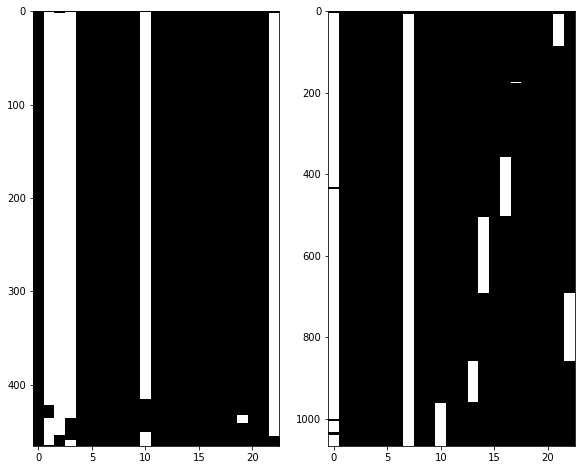

In [14]:
plt.figure(6,figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(A,cmap='gray',aspect='auto')
plt.subplot(1,3,2)
plt.imshow(C,cmap='gray',aspect='auto')

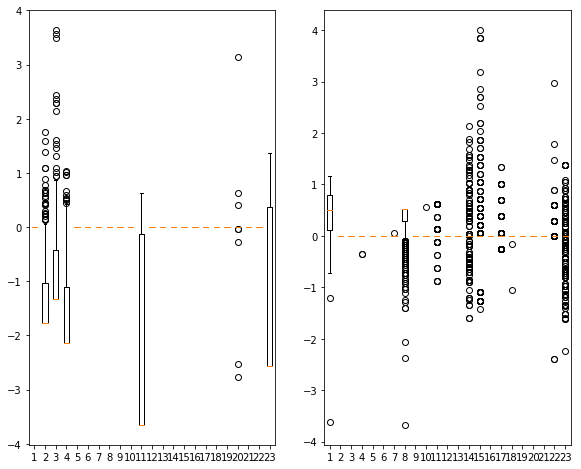

In [15]:
plt.figure(7,figsize=(15,8))

plt.subplot(1,3,1)
# plt.boxplot(A);
# plt.subplot(1,3,2)
plt.boxplot(rel_attrib_values_c0_pattern);


plt.subplot(1,3,2)
plt.boxplot(rel_attrib_values_c1_pattern);